In [27]:
import numpy as np
import pandas as pd
import io
import ipywidgets as widgets
from IPython.display import display

# Initialize data variable
data = None

# Create upload widget
uploader = widgets.FileUpload(accept=".csv", multiple=False)
display(uploader)

# Function to load uploaded CSV
def load_file(change):
    global data
    if uploader.value:
        uploaded_file = list(uploader.value.values())[0]  # get the uploaded file
        content = uploaded_file['content']
        data = pd.read_csv(io.BytesIO(content))          # read into pandas
        print("File uploaded successfully!")            # ✅ inside string
        print("Columns found:", data.columns)

# Observe the upload event
uploader.observe(load_file, names='value')

FileUpload(value={}, accept='.csv', description='Upload')

File uploaded successfully!
Columns found: Index(['timestamp', 'x', 'y', 'z', 'User', 'Epilepsy'], dtype='object')


Running Advanced Seizure Detection...
Total Peaks Detected: 356
⚠ Possible Seizure Activity Detected!
Peak Magnitude -> Mean: 3.46, Max: 5.47, Min: 2.85
Average Interval Between Peaks: 3.45 seconds
Duration of High Activity: 5039 samples
Duration of High Activity: 100.78 seconds (1.68 minutes)
⚠ High activity cluster detected from sample 29778 to 30072 (~5.88s)


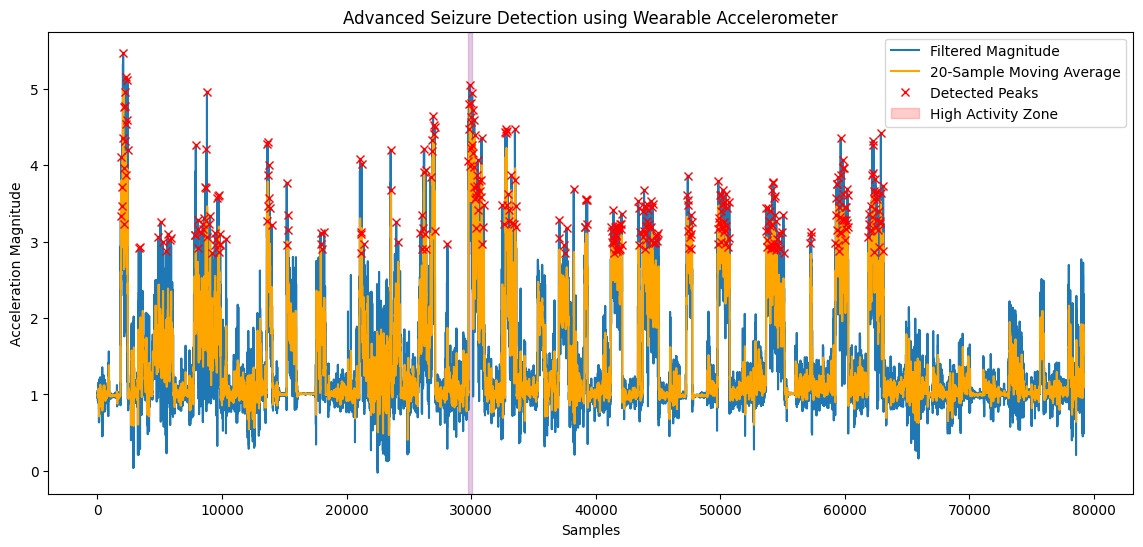

Summary CSV saved as 'seizure_summary.csv'.


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks

# ----- Check if data is uploaded -----
if 'data' not in globals():
    print("⚠ Please upload the CSV file first!")
else:
    print("Running Advanced Seizure Detection...")

    # 1. Ensure required columns exist
    required_cols = ['x','y','z']
    for col in required_cols:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' not found!")

    # 2. Compute acceleration magnitude
    data['magnitude'] = np.sqrt(data['x']**2 + data['y']**2 + data['z']**2)

    # 3. Apply low-pass filter
    def butter_lowpass_filter(signal, cutoff=5, fs=50, order=4):
        nyquist = 0.5 * fs
        normal_cutoff = cutoff / nyquist
        b, a = butter(order, normal_cutoff, btype='low')
        return filtfilt(b, a, signal)

    fs = 50  # sampling rate in Hz (adjust if different)
    data['filtered_mag'] = butter_lowpass_filter(data['magnitude'], fs=fs)

    # 4. Detect Peaks
    threshold = np.mean(data['filtered_mag']) + 2*np.std(data['filtered_mag'])
    peaks, properties = find_peaks(data['filtered_mag'], height=threshold, distance=20)
    peak_magnitudes = properties['peak_heights']

    print(f"Total Peaks Detected: {len(peaks)}")
    if len(peaks) > 10:
        print("⚠ Possible Seizure Activity Detected!")
    else:
        print("Normal Movement Pattern")

    # 5. Advanced Features

    # Peak Statistics
    peak_mean = np.mean(peak_magnitudes) if len(peaks) > 0 else 0
    peak_max = np.max(peak_magnitudes) if len(peaks) > 0 else 0
    peak_min = np.min(peak_magnitudes) if len(peaks) > 0 else 0
    print(f"Peak Magnitude -> Mean: {peak_mean:.2f}, Max: {peak_max:.2f}, Min: {peak_min:.2f}")

    # Peak Intervals
    if len(peaks) > 1:
        peak_intervals = np.diff(peaks)
        avg_interval_sec = np.mean(peak_intervals) / fs
        print(f"Average Interval Between Peaks: {avg_interval_sec:.2f} seconds")
    else:
        peak_intervals = []
        avg_interval_sec = 0

    # Moving Average
    window = 20
    data['moving_avg'] = data['filtered_mag'].rolling(window=window).mean()

    # Energy of Movement (over sliding window)
    energy_window = 20
    data['energy'] = data['filtered_mag'].rolling(window=energy_window).apply(lambda x: np.sum(x**2))

    # Duration of High Activity
    high_activity = data['filtered_mag'] > threshold
    high_activity_samples = high_activity.sum()
    duration_seconds = high_activity_samples / fs
    duration_minutes = duration_seconds / 60
    print(f"Duration of High Activity: {high_activity_samples} samples")
    print(f"Duration of High Activity: {duration_seconds:.2f} seconds ({duration_minutes:.2f} minutes)")

    # 6. Caregiver Alert Simulation
    # Alert if high activity occurs consecutively > 5 seconds
    high_activity_clusters = []
    cluster_start = None
    for i, val in enumerate(high_activity):
        if val and cluster_start is None:
            cluster_start = i
        elif not val and cluster_start is not None:
            cluster_end = i
            cluster_duration = (cluster_end - cluster_start)/fs
            if cluster_duration >= 5:  # threshold in seconds
                high_activity_clusters.append((cluster_start, cluster_end, cluster_duration))
                print(f"⚠ High activity cluster detected from sample {cluster_start} to {cluster_end} (~{cluster_duration:.2f}s)")
            cluster_start = None
    if cluster_start is not None:  # last cluster till end
        cluster_end = len(high_activity)
        cluster_duration = (cluster_end - cluster_start)/fs
        if cluster_duration >= 5:
            high_activity_clusters.append((cluster_start, cluster_end, cluster_duration))
            print(f"⚠ High activity cluster detected from sample {cluster_start} to {cluster_end} (~{cluster_duration:.2f}s)")

    # 7. Plotting Results
    plt.figure(figsize=(14,6))
    plt.plot(data['filtered_mag'], label="Filtered Magnitude")
    plt.plot(data['moving_avg'], label=f"{window}-Sample Moving Average", color='orange')
    plt.plot(peaks, data['filtered_mag'].iloc[peaks], "rx", label="Detected Peaks")
    plt.fill_between(data.index, threshold, data['filtered_mag'], where=data['filtered_mag']>threshold,
                     color='red', alpha=0.2, label="High Activity Zone")
    # Highlight clusters
    for start, end, dur in high_activity_clusters:
        plt.axvspan(start, end, color='purple', alpha=0.2)
    plt.title("Advanced Seizure Detection using Wearable Accelerometer")
    plt.xlabel("Samples")
    plt.ylabel("Acceleration Magnitude")
    plt.legend()
    plt.show()

    # 8. Optional: Save summary to CSV
    summary = pd.DataFrame({
        'Peak_Index': peaks,
        'Peak_Magnitude': peak_magnitudes
    })
    summary.to_csv("seizure_summary.csv", index=False)
    print("Summary CSV saved as 'seizure_summary.csv'.")